<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/Prophet_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U pandas prophet

     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638199 sha256=bf7ebcb0a5df243391de11f34e26448107aa92e0255942adc6fa0a6e4b88d980
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [21]:
import pickle
from prophet import Prophet
from matplotlib import pyplot as plt
from prophet.plot import add_changepoints_to_plot
import pandas as pd
import requests
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae

<h1>Другая модель</h1>
Добавляем в признаки 2 самые похожие страны

In [3]:
with open("people_structure.csv", 'wb') as f:
  f.write(requests.get("https://storage.yandexcloud.net/covid-19/people_structure.csv").content)

чтобы протестировать модель - нужно

1) Обрезать people_structure по datetime.now() - timedelta(days=30) (сложи всё что обрезала в y_true, чтобы это был нампай массив)

2) Брать данные по лагам за последние 30 дней

3) Смотреть MAE MAPE (sklearn)

В модели Phophet у нас там поле в предикте называется y_hat - бери f["yhat"].values

В итоге - 2 цифры (MAE и MAPE)

In [4]:
df_sec = pd.read_csv("people_structure.csv")

In [5]:
import json

In [6]:
lags = json.loads(requests.get("https://storage.yandexcloud.net/covid-19/lags_30.json").content)

In [7]:
def get_train_data(countries, source_country, cases, field):
  df = pd.DataFrame(index=cases[cases['location'] == source_country]["date"], columns=['y', 'ds'] + [i for i, _ in countries])
  df['y'] = cases[cases['location'] == source_country].reset_index().set_index("date")[field]
  df['ds'] = cases[cases['location'] == source_country].reset_index().set_index("date").index
  c = cases["location"].unique()
  columns = []
  values = []
  for country, info in countries:
    if country in c:
      df[country] = cases[cases["location"] == country][field]
    else:
      del df[country]
  return df.fillna(method='ffill').dropna()

In [8]:
# def get_train_data(countries, source_country, cases, field):
#   df = pd.DataFrame(index=cases[cases['location'] == source_country]["date"], columns=['y', 'ds'] + [i for i, _ in countries])
#   df['y'] = cases[cases['location'] == source_country].reset_index().set_index("date")[field]
#   df['ds'] = cases[cases['location'] == source_country].reset_index().set_index("date").index
#   c = cases["location"].unique()
#   for country, info in countries:
#     if country in c:
#       df[country] = cases[cases["location"] == country].reset_index().set_index("date")[field].shift(info["lag"])
#     else:
#       del df[country]
#   return df.fillna(method='ffill').dropna()

In [9]:
from datetime import datetime, date

def get_df_future(days_predict, m, countries, cases, field, train_last):
  d = pd.date_range(train_last, periods=days_predict + 1, closed='right')
  future = pd.DataFrame()
  future["ds"] = d

  g = cases['location'].unique()
  
  for country, info in countries:
    if country in g:
      future[country] = cases[cases['location'] == country][field].iloc[-days_predict + info["lag"]: info["lag"]].values
  
  return future.fillna(method='ffill')

In [10]:
def get_predict(days_predict, source_country, cases, lags) -> np.array:
  """
  Возвращает предикт и модель Prophet
  """
  countries = sorted(filter(lambda x: -x[1]["lag"] > days_predict, lags[source_country].items()), key=lambda x: x[1]["similarity"])[-2:]
  field = 'new_cases_smoothed'
  train = get_train_data(countries, source_country, cases, field)

  m = Prophet(
    daily_seasonality=False, 
    yearly_seasonality=True, 
    weekly_seasonality=True,
    changepoint_prior_scale=0.8,
    seasonality_mode='multiplicative'
  )
  for i in train.columns:
    if i != 'ds' and i != 'y':
      m.add_regressor(i, mode="multiplicative")
  m.fit(train)
  future = get_df_future(days_predict, m, countries, cases, field, train.index[-1])
  forecast = m.predict(future)

  return forecast['yhat'].values

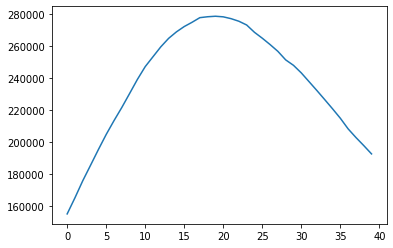

In [20]:
f = get_predict(40, "Russia", df_sec, lags)
# fig = plt.plot(f, figsize=(12, 4))
plt.plot(f);

In [23]:
f = get_predict(40, "Russia", df_sec, lags)

In [57]:
df_val = df_sec[pd.to_datetime(df_sec['date']) <= datetime.now() - pd.Timedelta(days=30)]

y_true = df_sec.sort_values(by='date').query("location == 'Russia'")['new_cases_smoothed'].values[-30 :]
y_pred = get_predict(30, "Russia", df_val, lags)


In [63]:
print('MAE:', round(mae(y_true, y_pred)), 'MAPE:', round(mape(y_true, y_pred), 6))

MAE: 31064 MAPE: 0.481466


In [18]:
# f["yhat"].values # predict модели